In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from tqdm import trange
import scipy.stats as stats
import seaborn as sns

In [2]:
n_epochs = 150
in_dim = 2
hidden_dims = [64]*3
out_dim = 1
B = 200
tau = 1e-3

In [3]:
class Net(nn.Module):
    def __init__(self, in_dim, hidden_dims, out_dim):
        super().__init__()
        layers = list()
        dims = [in_dim] + hidden_dims
        for dim_in, dim_out in zip(dims[:-1], dims[1:]):
            layers.append(nn.Linear(dim_in, dim_out))
            layers.append(nn.Tanh())

        layers.append(nn.Linear(dims[-1], out_dim))
        self.nn = nn.Sequential(*layers)

    def forward(self, x):
        return self.nn(x)

net = Net(in_dim, hidden_dims, out_dim)
criterion = torch.nn.BCEWithLogitsLoss()

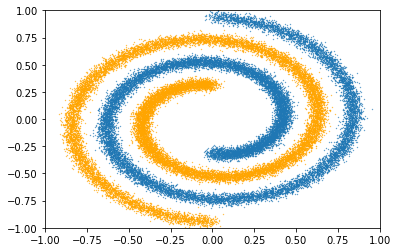

In [4]:
from sklearn.datasets import make_swiss_roll
data1 = make_swiss_roll(n_samples=20000, noise=0.4)[0]
data1 = data1.astype("float32")[:, [0, 2]]/15
labels1 = np.zeros(data1.shape[0])

data2 = make_swiss_roll(n_samples=20000, noise=0.4)[0]
data2 = -data2.astype("float32")[:, [0, 2]]/15
# data2 = (np.array([[1, 0], [0, 1]]) @ data2.T).T
labels2 = np.ones(data2.shape[0])

plt.scatter(*zip(*data1), s=0.1)
plt.scatter(*zip(*data2), s=0.1, color='orange')
plt.xlim([-1, 1])
plt.ylim([-1, 1])

plt.show()

In [5]:
labels = np.concatenate((labels1, labels2))[:, None]
data = np.concatenate((data1, data2), axis=0)
dataset = torch.utils.data.TensorDataset(torch.Tensor(data), torch.Tensor(labels))
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=B, shuffle=True
)

In [6]:
t0 = time.time()
loss_list = list()
T = 1
alpha = 0.9
with trange(n_epochs, desc="All epochs") as epochs:
    for e in epochs:
        for i, (data, labels) in enumerate(data_loader):
            preds = net(data)
            goal = -criterion(preds, labels)
            with torch.no_grad():
                net.zero_grad()
                goal.backward()
                for par in net.parameters():
                    noise_term = np.sqrt(2*tau*T) * torch.randn_like(par.data)
                    change = tau * (par.grad) + noise_term

                    par.add_(change)
            loss_list.append(-goal.detach().item())
            if i % 10 == 0:
                epochs.set_postfix(goal = loss_list[-1])
        T = T * alpha


t1 = time.time()
print(f'Total training time: {t1-t0:.4f}')

All epochs: 100%|██████████| 150/150 [01:03<00:00,  2.35it/s, goal=0.0353]

Total training time: 63.8280


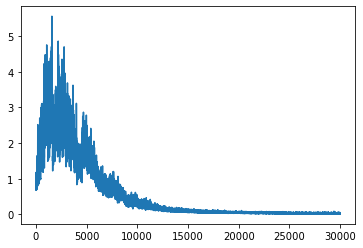

In [7]:
plt.plot(loss_list)
plt.show()

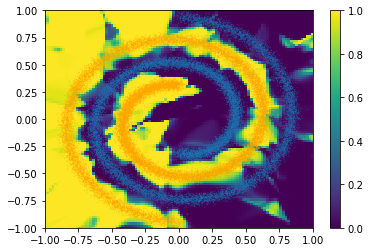

In [8]:
def plot_true():
    x = np.linspace(-1, 1, 101)
    y = np.linspace(-1, 1, 101)
    xx, yy = np.meshgrid(x, y)
    data = np.hstack((xx.ravel().reshape(-1,1), 
                      yy.ravel().reshape(-1,1)))
    data_t = torch.FloatTensor(data)

    px = torch.sigmoid(net(data_t))
    px = px.detach().numpy()
    px = np.reshape(px, xx.shape)
    plt.pcolormesh(x, y, px, shading='auto')
    plt.colorbar()

plot_true()
    
plt.scatter(*zip(*data1), s=0.1, alpha=0.4)
plt.scatter(*zip(*data2), s=0.1, color='orange', alpha=0.4)
plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.show()